# Final Exam AML


## 1. Classification Project




In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aseemdandgaval/23-pet-breeds-image-classification")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/aseemdandgaval/23-pet-breeds-image-classification/versions/2


In [9]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import torch.nn as nn
from torchvision import models
import torch.optim as optim

In [10]:
data_dir = '/root/.cache/kagglehub/datasets/aseemdandgaval/23-pet-breeds-image-classification/versions/2/Pet_Breeds'  # Укажите путь к папке с 23 подкатегориями

# Преобразования для изображений
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Нормализация для моделей ImageNet
])

# Загрузка датасета
full_dataset = datasets.ImageFolder(data_dir, transform=transform)

# Отображение всех классов в датасете
classes = full_dataset.classes
print(f"Классы в датасете: {classes}")

# Разделение на тренировочный, валидационный и тестовый наборы
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

print(f"Размеры наборов данных: train={len(train_dataset)}, val={len(val_dataset)}, test={len(test_dataset)}")

# Создание DataLoader для каждого набора данных
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


Классы в датасете: ['abyssinian', 'american shorthair', 'beagle', 'boxer', 'bulldog', 'chihuahua', 'corgi', 'dachshund', 'german shepherd', 'golden retriever', 'husky', 'labrador', 'maine coon', 'mumbai cat', 'persian cat', 'pomeranian', 'pug', 'ragdoll cat', 'rottwiler', 'shiba inu', 'siamese cat', 'sphynx', 'yorkshire terrier']
Размеры наборов данных: train=2716, val=582, test=583


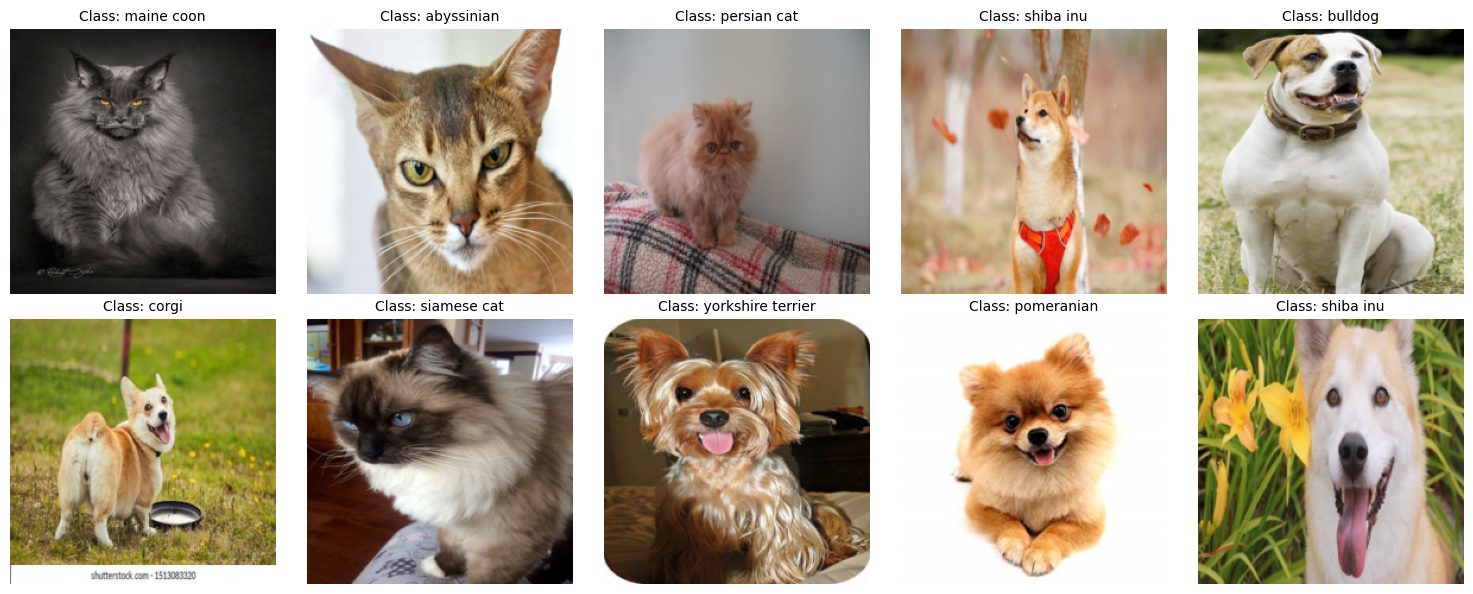

In [11]:
# Отображение 10 изображений с соответствующими классами
def display_images_with_labels(inputs, labels, classes, num_images=10, nrow=5):
    # Создаем фигуру для отображения
    fig, axes = plt.subplots(nrows=(num_images // nrow), ncols=nrow, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(num_images):
        image = inputs[i].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean  # Денормализация
        image = np.clip(image, 0, 1)

        axes[i].imshow(image)
        axes[i].set_title(f"Class: {classes[labels[i]]}", fontsize=10)
        axes[i].axis("off")

    # Убираем лишние пустые оси (если есть)
    for ax in axes[num_images:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


# Пример использования функции
inputs, labels = next(iter(train_loader))
display_images_with_labels(inputs[:10], labels[:10], classes, num_images=10, nrow=5)


In [12]:
base_model = models.resnet18(pretrained=True)

# Изменение последнего слоя
num_features = base_model.fc.in_features
base_model.fc = nn.Linear(num_features, len(full_dataset.classes))  # Количество классов

In [6]:
train_losses = []
val_accuracies = []

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):

    for epoch in range(num_epochs):
        start_time = time.time()
        print(f"Epoch {epoch + 1} of {num_epochs}")

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'train':
                train_losses.append(epoch_loss)  # Добавляем значение потерь в список
                print(f"  training loss (in-iteration): \t{epoch_loss:.6f}")
            else:
                val_accuracies.append(epoch_acc)  # Добавляем значение точности в список
                print(f"  validation accuracy: \t\t\t{epoch_acc:.2%}")

        end_time = time.time()
        print(f"Epoch {epoch + 1} took {end_time - start_time:.3f}s\n")

    return model

In [13]:
# Подготовка компонентов
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(base_model.parameters(), lr=0.001, momentum=0.9)

# Создание словаря с DataLoader
dataloaders = {'train': train_loader, 'val': val_loader}

# Обучение базовой модели
base_model = train_model(base_model, dataloaders, criterion, optimizer, num_epochs=10)


Epoch 1 of 10
  training loss (in-iteration): 	3.009361
  validation accuracy: 			36.94%
Epoch 1 took 965.502s

Epoch 2 of 10
  training loss (in-iteration): 	2.100008
  validation accuracy: 			70.10%
Epoch 2 took 979.878s

Epoch 3 of 10
  training loss (in-iteration): 	1.400456
  validation accuracy: 			76.29%
Epoch 3 took 963.752s

Epoch 4 of 10
  training loss (in-iteration): 	1.010341
  validation accuracy: 			80.58%
Epoch 4 took 967.106s

Epoch 5 of 10
  training loss (in-iteration): 	0.793064
  validation accuracy: 			84.88%
Epoch 5 took 961.061s

Epoch 6 of 10
  training loss (in-iteration): 	0.654684
  validation accuracy: 			85.22%
Epoch 6 took 962.915s

Epoch 7 of 10
  training loss (in-iteration): 	0.557636
  validation accuracy: 			85.74%
Epoch 7 took 961.657s

Epoch 8 of 10
  training loss (in-iteration): 	0.484039
  validation accuracy: 			86.43%
Epoch 8 took 955.763s

Epoch 9 of 10
  training loss (in-iteration): 	0.428000
  validation accuracy: 			86.43%
Epoch 9 took 94

In [14]:
import numpy as np

# Вычисляем средние значения после завершения обучения
avg_train_loss = np.mean(train_losses)
avg_val_accuracy = np.mean(val_accuracies)

print(f"Average Training Loss: {avg_train_loss:.6f}")
print(f"Average Validation Accuracy: {avg_val_accuracy:.2%}")

Average Training Loss: 1.082245
Average Validation Accuracy: 77.94%


In [15]:
def visualize_predictions(model, dataloader, classes, num_images=8):
    model.eval()
    inputs, labels = next(iter(dataloader))
    outputs = model(inputs)
    probs = torch.nn.functional.softmax(outputs, dim=1)  # Вычисление вероятностей
    _, preds = torch.max(outputs, 1)

    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(num_images):
        image = inputs[i].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

        axes[i].imshow(image)

        # Добавление вероятности в заголовок
        prob = probs[i][preds[i]].item()  # Получение вероятности для предсказанного класса
        title = f"Pred: {classes[preds[i]]} ({prob:.2f}), True: {classes[labels[i]]}"
        axes[i].set_title(title, fontsize=10)

        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

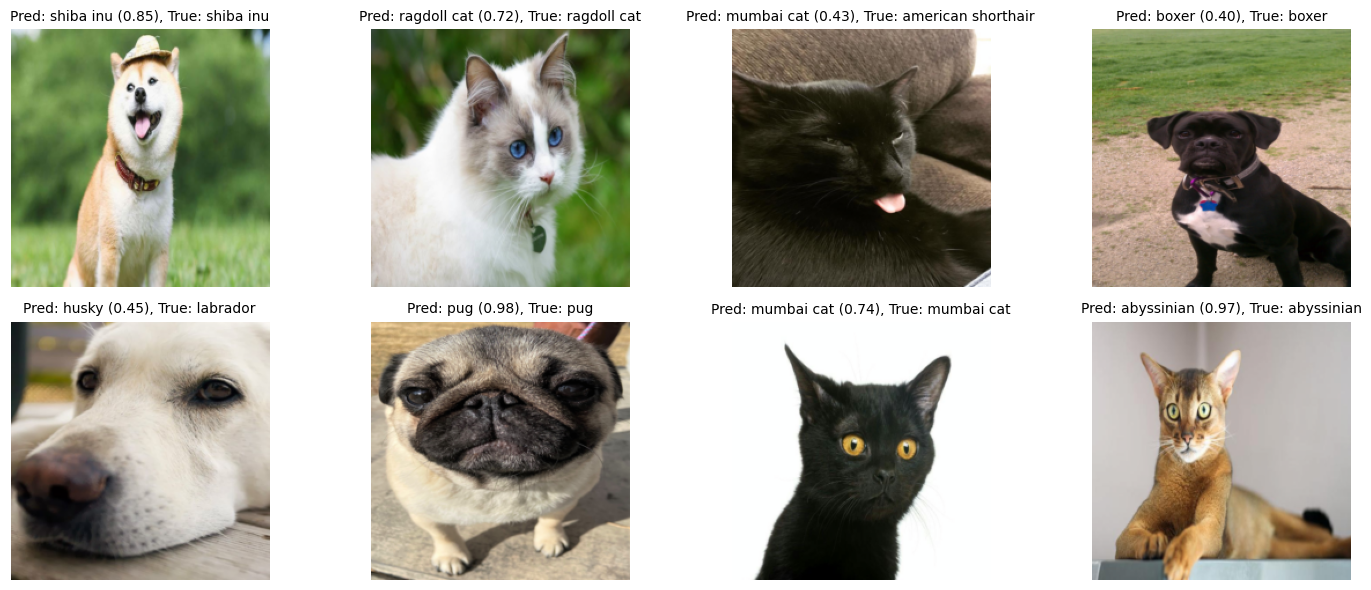

In [16]:
visualize_predictions(base_model, val_loader, full_dataset.classes, num_images=8)  # num_images=8 для 8 фото

In [17]:
class ImprovedModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super(ImprovedModel, self).__init__()
        self.features = nn.Sequential(*list(base_model.children())[:-1])  # Все кроме последнего слоя
        self.classifier = nn.Sequential(
            nn.Linear(base_model.fc.in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

improved_model = ImprovedModel(base_model, len(full_dataset.classes))

# Обучение улучшенной модели
optimizer = optim.SGD(improved_model.parameters(), lr=0.001, momentum=0.9)

improved_model = train_model(improved_model, dataloaders, criterion, optimizer, num_epochs=10)


Epoch 1 of 10
  training loss (in-iteration): 	2.461394
  validation accuracy: 			75.95%
Epoch 1 took 954.492s

Epoch 2 of 10
  training loss (in-iteration): 	0.912388
  validation accuracy: 			85.74%
Epoch 2 took 954.066s

Epoch 3 of 10
  training loss (in-iteration): 	0.539357
  validation accuracy: 			87.63%
Epoch 3 took 954.820s

Epoch 4 of 10
  training loss (in-iteration): 	0.404940
  validation accuracy: 			86.94%
Epoch 4 took 952.071s

Epoch 5 of 10
  training loss (in-iteration): 	0.330990
  validation accuracy: 			88.49%
Epoch 5 took 951.016s

Epoch 6 of 10
  training loss (in-iteration): 	0.274436
  validation accuracy: 			88.14%
Epoch 6 took 957.309s

Epoch 7 of 10
  training loss (in-iteration): 	0.243319
  validation accuracy: 			87.97%
Epoch 7 took 955.821s

Epoch 8 of 10
  training loss (in-iteration): 	0.207634
  validation accuracy: 			88.66%
Epoch 8 took 946.352s

Epoch 9 of 10
  training loss (in-iteration): 	0.180201
  validation accuracy: 			88.32%
Epoch 9 took 95

In [18]:
import numpy as np

# Вычисляем средние значения после завершения обучения
avg_train_loss = np.mean(train_losses)
avg_val_accuracy = np.mean(val_accuracies)

print(f"Average Training Loss: {avg_train_loss:.6f}")
print(f"Average Validation Accuracy: {avg_val_accuracy:.2%}")

Average Training Loss: 0.826804
Average Validation Accuracy: 82.27%


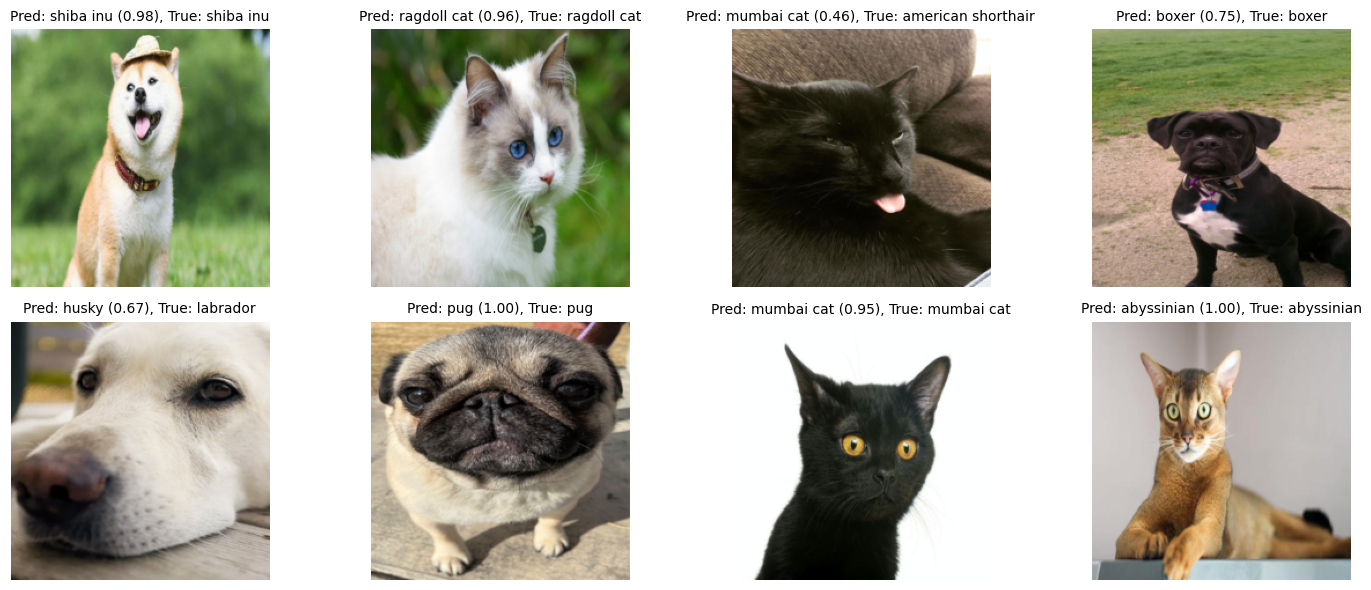

In [19]:
visualize_predictions(improved_model, val_loader, full_dataset.classes, num_images=8)  # num_images=8 для 8 фото

In [20]:
# Сохранить состояние модели в файл 'improved_model.pth'
torch.save(improved_model.state_dict(), 'improved_model.pth')

In [23]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 2.8 MB/s eta 0:00:00


In [27]:
from torcheval.metrics import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score

def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    # Инициализация метрик
    accuracy = MulticlassAccuracy(num_classes=23) # 23 класса
    precision = MulticlassPrecision(num_classes=23, average='macro')
    recall = MulticlassRecall(num_classes=23, average='macro')
    f1 = MulticlassF1Score(num_classes=23, average='macro')

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # Обновление метрик
            accuracy.update(preds, labels)
            precision.update(preds, labels)
            recall.update(preds, labels)
            f1.update(preds, labels)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    # Вычисление и вывод результатов
    print(f"Test Loss: {epoch_loss:.4f}")
    print(f"Test Accuracy: {epoch_acc:.2%}")
    print(f"Precision: {precision.compute():.2%}")
    print(f"Recall: {recall.compute():.2%}")
    print(f"F1 Score: {f1.compute():.2%}")

# Пример использования:
evaluate_model(improved_model, test_loader, criterion)

Test Loss: 0.3517
Test Accuracy: 90.05%
Precision: 89.90%
Recall: 90.10%
F1 Score: 89.78%


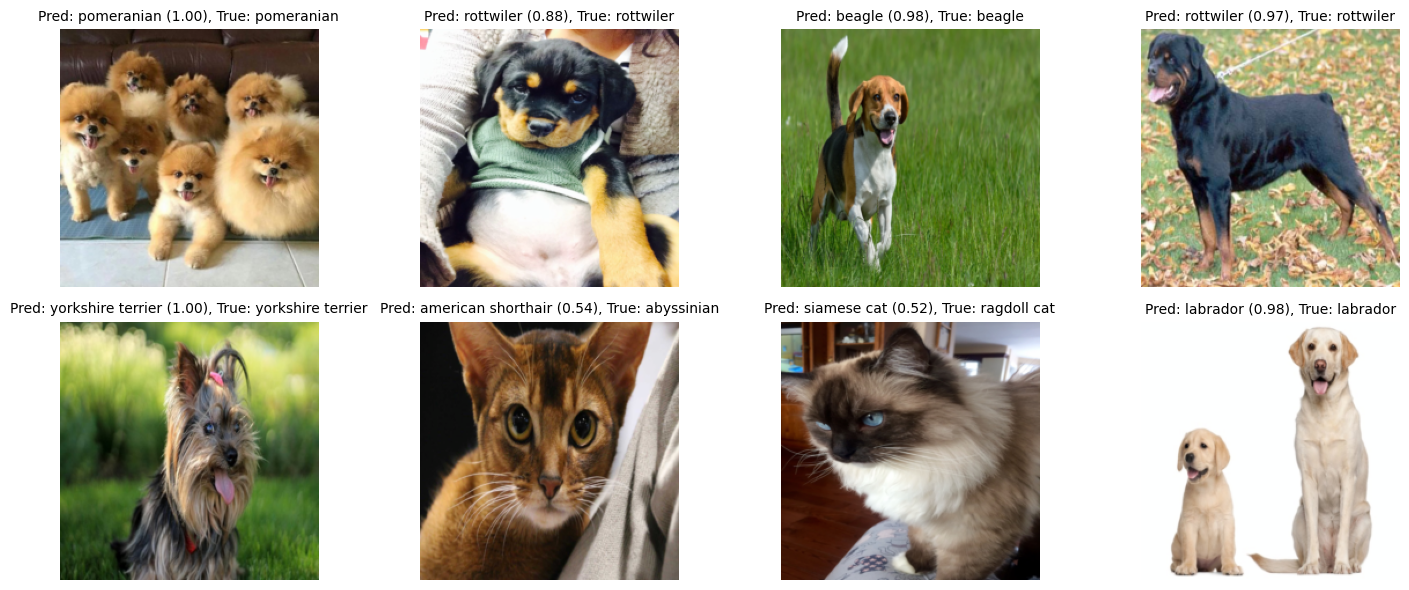

In [28]:
visualize_predictions(improved_model, test_loader, full_dataset.classes, num_images=8)

In [34]:
pip install gdown
